In [75]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import importlib
import plotly.express as px
import os
import glob
import pandas as pd
import json

import utils.db_tools as db_tools
from utils.db_tools import (
    get_db,
    filter_df,
    make_animation,
    get_data,
    metrics_grid,
    plot_grid,
    compute_metrics,
    plot_all_trajectories
)

from classify import classify_trajectories

importlib.reload(db_tools)

<module 'utils.db_tools' from '/cluster/home/vogtva/pde-solvers-cuda/analysis/utils/db_tools.py'>

In [76]:
model = "bruss"
run_id = "phase_transition"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")

output_dir = os.path.join(output_dir, model, run_id)
df = pd.read_csv(os.path.join(output_dir, "classification_metrics.csv"))
df_class = classify_trajectories(df)
df = df_class.copy()
df = df[df["filename"].apply(os.path.exists)].reset_index(drop=True)

In [77]:
# df = df0[(df0.A >= 0.7) & (df0.A <= 1.9)].copy()
df.loc[:, "ba"] = df["B"] / df["A"]

In [78]:
df.head()

,Unnamed: 0,model,A,B,Nx,dx,Nt,dt,Du,Dv,...,max_dx,mean_dx,max_dt,mean_dt,dominant_power,total_power,max_u,max_v,category,ba
0,0,bruss,1.5,3.150,128,1.0,60000,0.0025,2.0,22.0,...,0.000001,4.708767e-07,25.840044,12.761797,0.007842,0.130487,1.604546,2.221654,DSS,2.10
1,1,bruss,1.9,3.933,128,1.0,60000,0.0025,2.0,22.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.002431,0.165687,2.061864,2.136643,SS,2.07
2,2,bruss,2.1,4.179,128,1.0,60000,0.0025,2.0,22.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000256,0.019798,2.119175,2.131417,SS,1.99
3,3,bruss,2.4,4.776,128,1.0,60000,0.0025,2.0,22.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000120,0.010184,2.407544,2.002457,SS,1.99
4,4,bruss,2.0,4.040,128,1.0,60000,0.0025,2.0,22.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000887,0.063381,2.022112,2.031357,SS,2.02


In [79]:
df1 = df[df.A == 0.7]
df1 = df1.sort_values("ba")

In [80]:
def first_double_large_jump(arr: np.ndarray) -> int:
    diffs = np.diff(arr)  # Compute differences
    large_jumps = diffs > 1  # Identify where the difference is > 1
    consecutive = np.where(large_jumps[:-1] & large_jumps[1:])[0]  # Find consecutive indices
    return consecutive[0] if consecutive.size > 0 else -1

first_double_large_jump(df1["mean_deviation"])

36

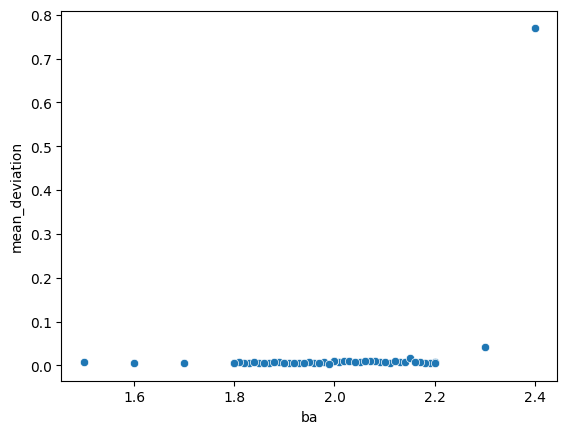

A = 0.60, B/A = 2.20


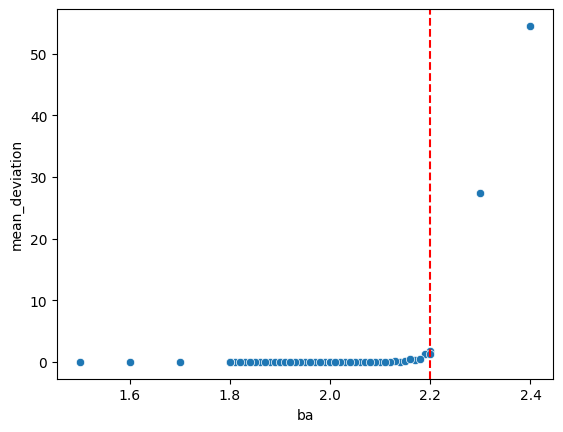

A = 0.70, B/A = 2.10


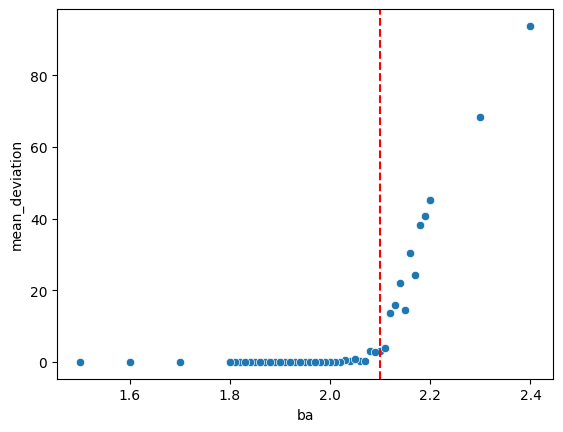

A = 0.80, B/A = 2.03


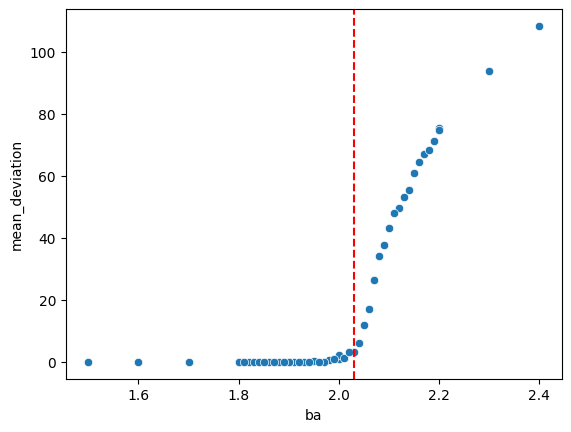

A = 0.90, B/A = 2.01


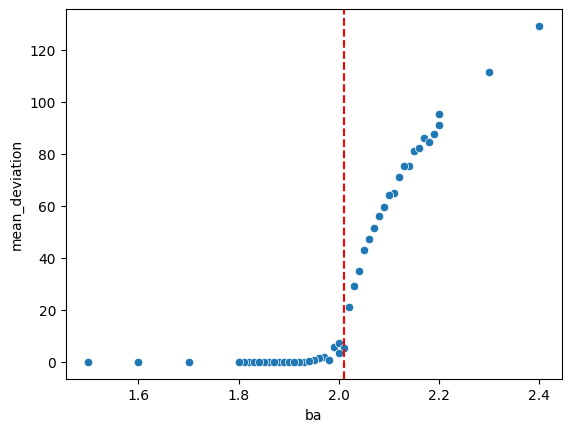

A = 1.00, B/A = 1.96


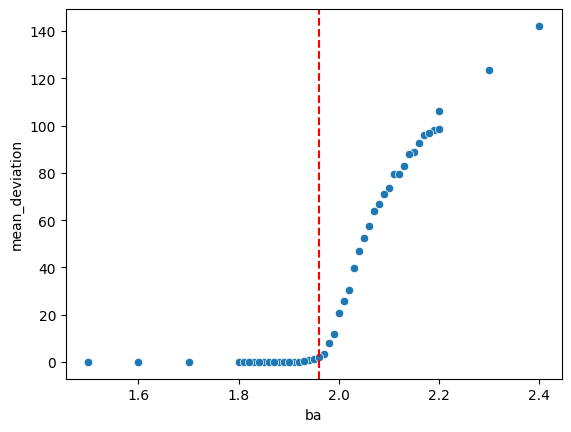

A = 1.10, B/A = 1.96


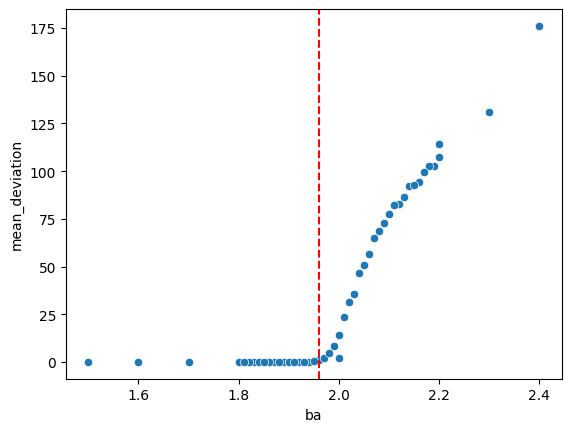

A = 1.20, B/A = 2.00


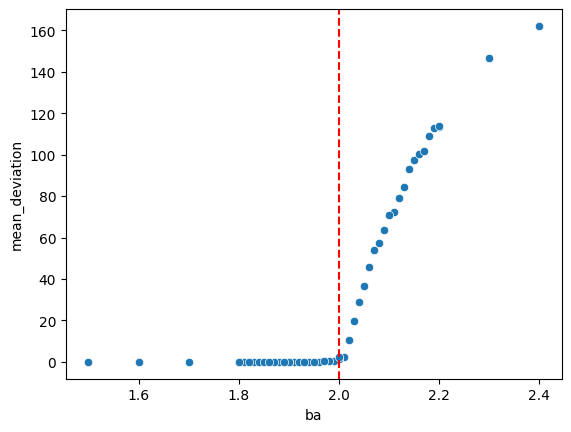

A = 1.30, B/A = 2.04


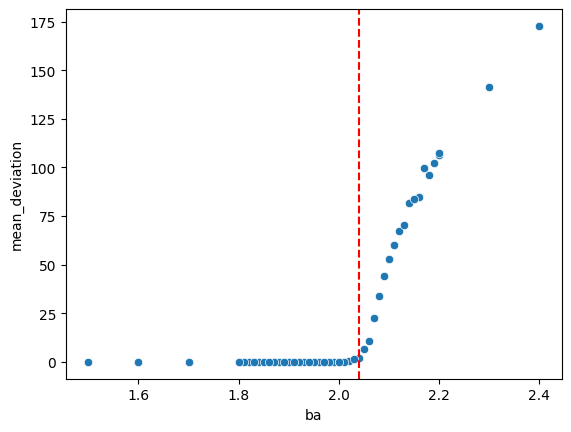

A = 1.40, B/A = 2.10


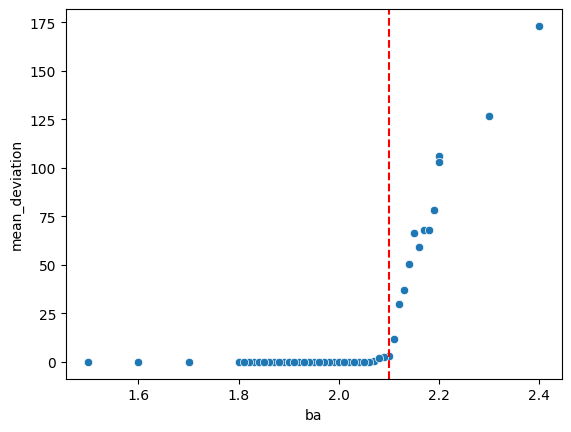

A = 1.50, B/A = 2.14


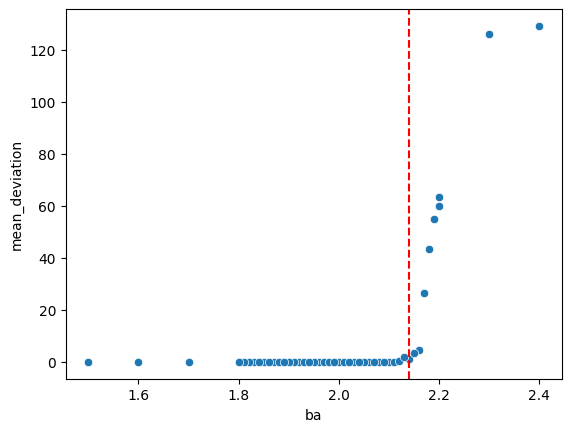

A = 1.60, B/A = 2.20


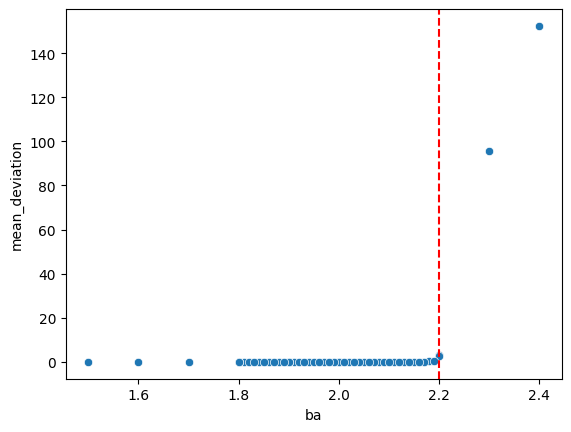

A = 1.70, B/A = 2.20


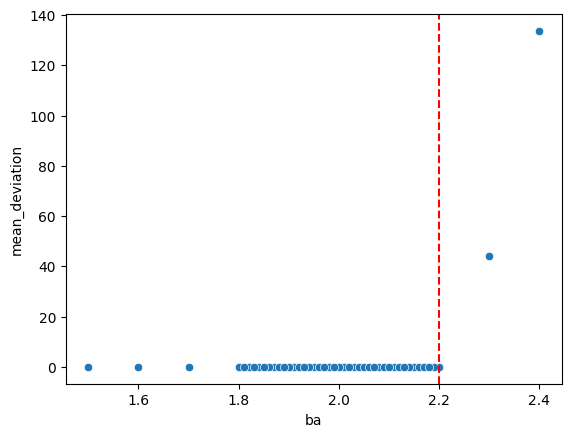

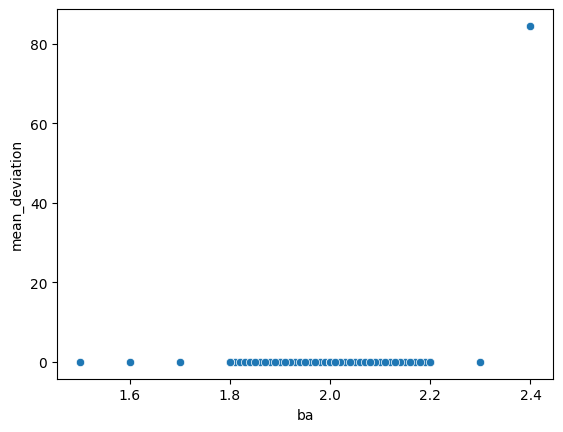

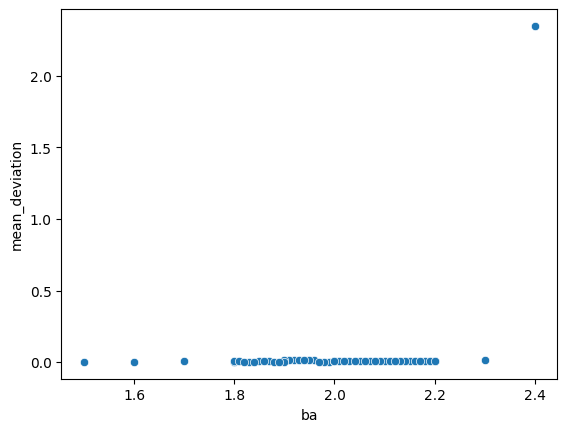

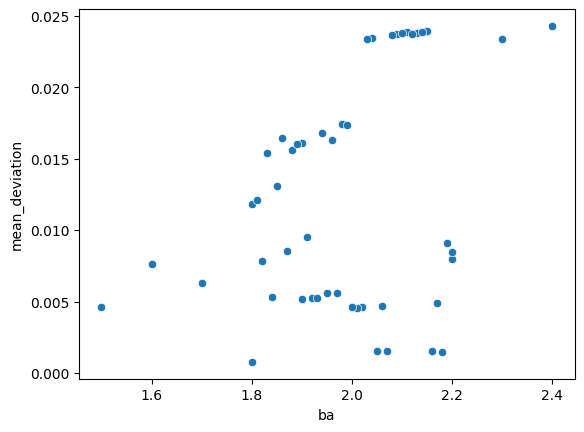

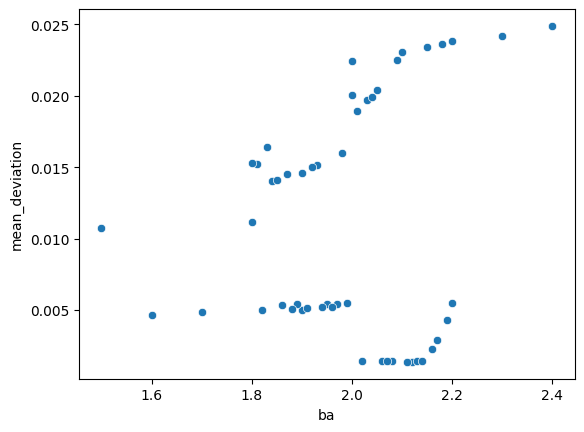

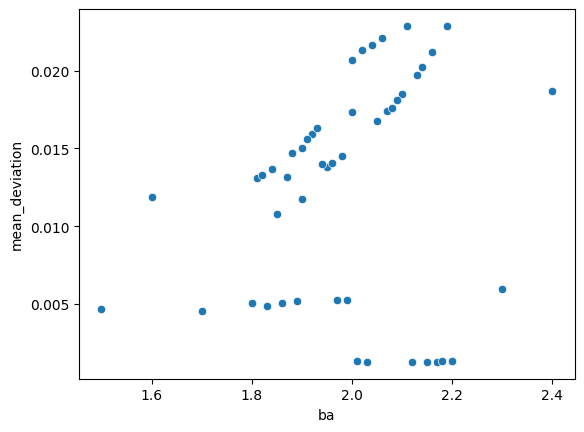

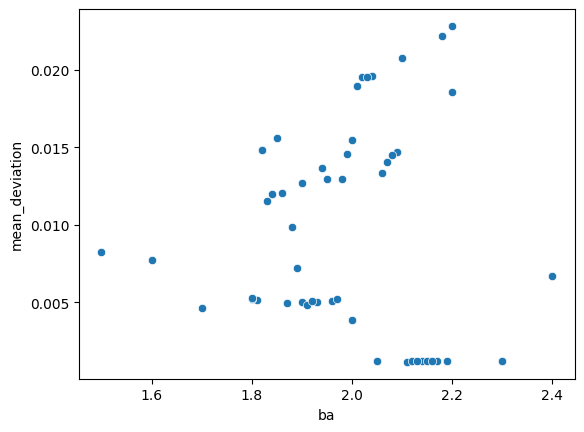

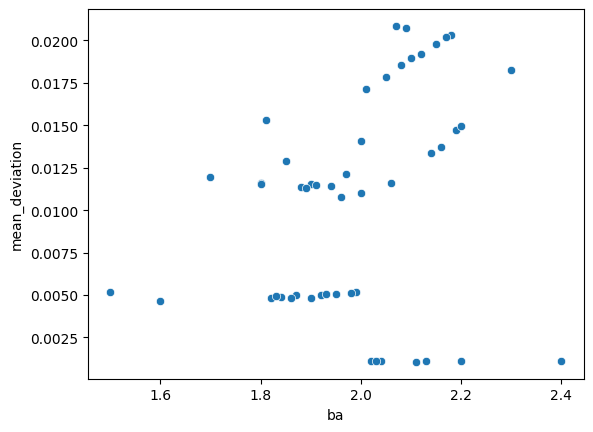

In [81]:
A_arr = []
c_arr = []
for A, df_filt in df.groupby("A"):
    metric = "mean_deviation"
    sns.scatterplot(data=df_filt, x='ba', y=metric) #, ax=axes[0])
    df1 = df_filt.sort_values("ba")
    mean_dev = df1["mean_deviation"]
    idx = first_double_large_jump(mean_dev)
    if idx != -1:
        print(f"A = {A:.2f}, B/A = {df1.iloc[idx]['ba']:.2f}")
        A_arr.append(A)
        c_arr.append(df1.iloc[idx]['ba'])
        # print(A, )
        plt.axvline(x=df1.iloc[idx]["ba"], color='r', linestyle='--')
    plt.show()

[ 0.72927073 -1.59340659  2.85938561]


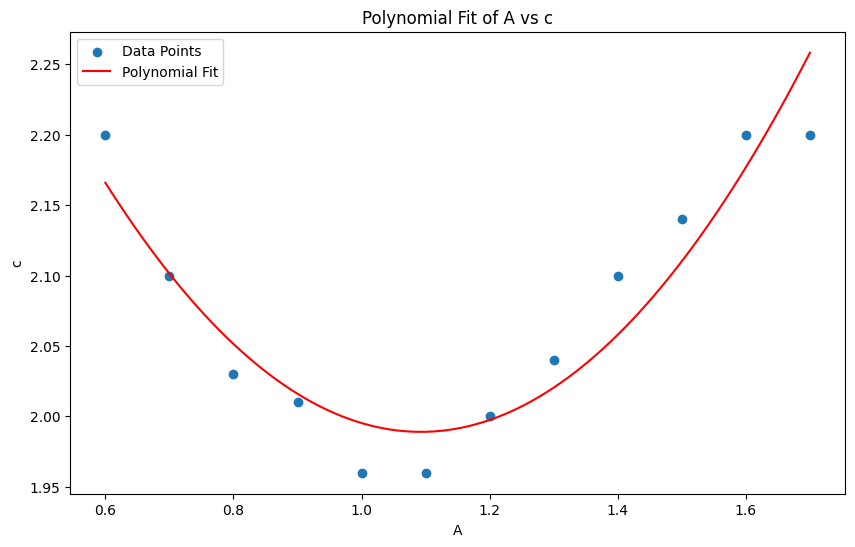

In [82]:
# Perform polynomial fit
coefficients = np.polyfit(A_arr, c_arr, deg=2)
polynomial = np.poly1d(coefficients)
print(coefficients)
# Generate x values for plotting the polynomial
x_vals = np.linspace(min(A_arr), max(A_arr), 100)
y_vals = polynomial(x_vals)

# Plot the data points and the polynomial fit
plt.figure(figsize=(10, 6))
plt.scatter(A_arr, c_arr, label='Data Points')
plt.plot(x_vals, y_vals, color='red', label='Polynomial Fit')
plt.xlabel('A')
plt.ylabel('c')
plt.title('Polynomial Fit of A vs c')
plt.legend()
plt.show()

In [90]:
df_new = pd.DataFrame(columns=["A", "B", "Du", "Dv"])

A_all = np.arange(0.5, 2.5, 0.1)
A_around_min = np.arange(1.0, 1.2, 0.01)
A_values = np.concatenate((A_all, A_around_min))
A_values = np.unique(A_values)
A_values = np.sort(A_values)
for A in A_values:
    B_A_center = polynomial(A)
    B_A_fine = np.linspace(B_A_center - 0.1, B_A_center + 0.1, 50)
    B_A_coarse = np.linspace(B_A_center - 0.5, B_A_center + 0.5, 40)

    B_A_values = np.concatenate((B_A_fine, B_A_coarse))
    B_A_values = np.unique(B_A_values)

    for B_A in B_A_values:
        df_new.loc[len(df_new)] = [A, B_A * A, 2.0, 22.0]

In [92]:
df_new.to_csv("../data/pt.csv")